In [51]:
%matplotlib inline
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import h5py
import cv2 as cv
from keras.utils import to_categorical

# Loading the Datasets

In [52]:
f = h5py.File('MNIST_synthetic.h5', 'r')
print(f.keys())

X_tr = torch.from_numpy(np.array(f['train_dataset']).astype(np.float32).squeeze()) 
Y_tr = torch.from_numpy(np.array(f['train_labels'])) #.astype(np.float32)?
X_test = torch.from_numpy(np.array(f['test_dataset']).astype(np.float32).squeeze()) 

X_tr.requires_grad = True
#X_test.requires_grad = True

print(X_tr.shape)
print(Y_tr.shape)
print(X_test.shape)

# Crop image
X_tr = X_tr[:, 26:38,:]
X_test = X_test[:,26:38,:]

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>
torch.Size([56000, 64, 64])
torch.Size([56000, 5])
torch.Size([14000, 64, 64])


# Helper Method To Retrieve Individual Digits In A Single 64x64 Image

In [53]:
# Cong suggested a better way perhaps ? To implement this 
def retrieveDigits(x_input, nb_Digits): 
    digits = [] #List of digits of size 12x12 
    if nb_Digits == 1 : 
        digits.append(x_input[:,26:38])
    elif nb_Digits == 2 : 
        digits.append(x_input[:,20:32])
        digits.append(x_input[:,32:44])
    elif nb_Digits == 3 : 
        digits.append(x_input[:,14:26])
        digits.append(x_input[:,26:38])
        digits.append(x_input[:,38:50])
    elif nb_Digits == 4 :
        digits.append(x_input[:,8:20])
        digits.append(x_input[:,20:32])
        digits.append(x_input[:,32:44])
        digits.append(x_input[:,44:56])
    elif nb_Digits == 5: 
        digits.append(x_input[:, 2:14])
        digits.append(x_input[:,14:26])
        digits.append(x_input[:,26:38])
        digits.append(x_input[:,38:50])
        digits.append(x_input[:,50:62])
    return digits

4


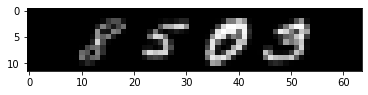

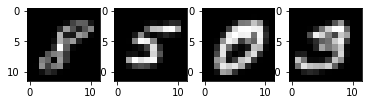

5


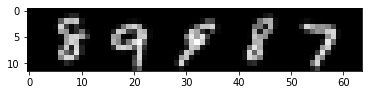

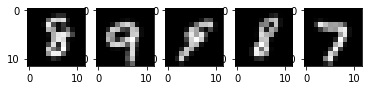

5


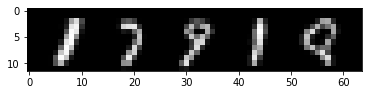

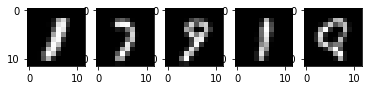

3


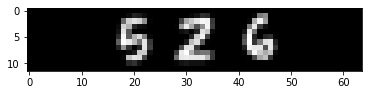

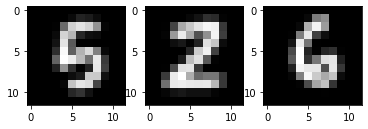

1


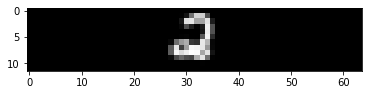

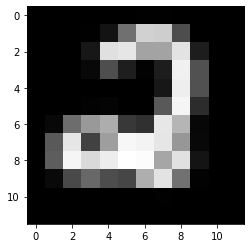

3


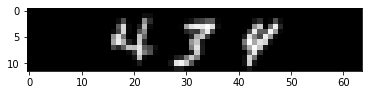

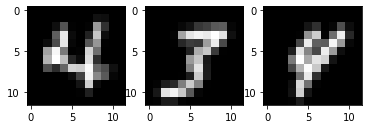

In [54]:
# Example visualization : 
for i in np.arange(6): 
    testImage = X_tr[i]
    nbDigits = 5-(Y_tr[i]==10).sum().item()
    digits = retrieveDigits(testImage, nbDigits)
    print(nbDigits)
    
    fig, ax0 = plt.subplots()
    with torch.no_grad():
        ax0.imshow(testImage, cmap='gray')
    
    if nbDigits ==1 : 
        fig2, ax = plt.subplots()
        with torch.no_grad(): 
            ax.imshow(digits[0],cmap='gray')
    else: 
        fig2, axs = plt.subplots(1,nbDigits)
        for ax in np.arange(0,nbDigits): 
            with torch.no_grad(): 
                axs[ax].imshow(digits[ax], cmap='gray')
    
    plt.show()

# Use openCV To Count Number Of Digits In An Image Instance. 
Don't know if we actually need to implement a HELPER CNN model... Could we use openCV to achieve this?

In [55]:
Y_tr_NbOfDigits = torch.zeros(Y_tr.shape[0], 1, dtype=Y_tr.dtype) + 5
for i in range(Y_tr.shape[0]): 
    Y_tr_NbOfDigits[i] -= (Y_tr[i]==10).sum()
print(Y_tr_NbOfDigits[:6])

tensor([[4],
        [5],
        [5],
        [3],
        [1],
        [3]], dtype=torch.int32)


## Write the Helper Method Using findContour And Adjusting Image 

In [56]:
def nbOfDigitsInImage(originalImage,visualize=False): 
    image = originalImage.detach().numpy()[:,:,np.newaxis].astype(np.uint8)
    image_blur = cv.GaussianBlur(image, (5,5), 0)[:,:,np.newaxis]
    _,image_thresh= cv.threshold(image_blur, 20, 255, cv.THRESH_BINARY)
    
    contours, hierarchy= cv.findContours(image_thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    nbDigits = len(contours)
    
    #Checking to see if our contour is too small: we may have dot-shaped noises in the contour sometimes that we 
    #shouldn't count as contours 
    for i in range(len(contours)): 
        if contours[i].shape[0]<10: 
            nbDigits-=1
    
    #This fixes some digits that are put in as one contour because they are too close to each other 
    for i in range(len(contours)): 
        contour = contours[i]
        minX = 10000
        maxX = -10000
        for pixel in range(contour.shape[0]): 
            if contour[pixel, 0, 0] < minX : 
                minX = contour[pixel, 0, 0]
            if contour[pixel, 0, 0] > maxX :
                maxX = contour[pixel, 0, 0]
        if maxX-minX >12: 
            nbDigits+=1
            

    if visualize: 
        # For visualization
        fig, axs = plt.subplots(3)
        axs[0].set_title('Original Image')
        axs[0].imshow(image[:,:,0], cmap='gray')

        axs[1].set_title('Blurred Image')
        axs[1].imshow(image_blur[:,:,0], cmap='gray')

        image_thresh = image_thresh[:,:,np.newaxis]
        axs[2].set_title('Threshold Applied')
        axs[2].imshow(image_thresh[:,:,0], cmap='gray')
        print(len(contours), 'digits in this instance!')
        plt.show()
        
    if nbDigits>5: 
        return 5
    else: 
        return nbDigits

In [57]:
# NOTE: MAYBE WE CAN DO BETTER BY ADJUSTING PARAMETERS IN ABOVE FUNCTION, BUT LET'S PROCEED ON FOR NOW 
total = X_tr.shape[0]
wrong = 0
visualizeWrongPredictions = 3
noisyIndexes = []

for im in range(total): 
    if nbOfDigitsInImage(X_tr[im]) != Y_tr_NbOfDigits[im]: 
        noisyIndexes.append(im)
        wrong += 1
        if visualizeWrongPredictions>0: 
            nbOfDigitsInImage(X_tr[im], visualize=True) #Visualize some of the wrong results
            visualizeWrongPredictions-=1

print("Wrong instances: ", wrong)
print("Error rate: ",(wrong/total)*100, " %")

Wrong instances:  0
Error rate:  0.0  %


# Final Pre-Processing Of Data 

## Remove the noisy data in our training set to facilitate training of our CNN digit classifier. 

In [58]:
X_tr = np.delete(X_tr.detach(), noisyIndexes, axis=0)
Y_tr = np.delete(Y_tr, noisyIndexes, axis=0)
Y_tr_NbOfDigits = np.delete(Y_tr_NbOfDigits, noisyIndexes, axis=0)

print(X_tr.shape)
print(Y_tr.shape)
print(Y_tr_NbOfDigits.shape)

torch.Size([56000, 12, 64])
torch.Size([56000, 5])
torch.Size([56000, 1])


In [59]:
# 
X_validation = X_tr[55999:]
Y_validation = Y_tr[55999:]
Y_val_NbOfDigits = Y_tr_NbOfDigits[55999:]

X_training = X_tr[:55999]
Y_training = Y_tr[:55999]
Y_tr_NbOfDigits=Y_tr_NbOfDigits[:55999]

train = torch.utils.data.TensorDataset(X_training,Y_training)
train_loader = torch.utils.data.DataLoader(train, batch_size = 4, shuffle = False)

print(X_training.shape)
print(Y_training.shape)
print(Y_tr_NbOfDigits.shape)
print(X_validation.shape)
print(Y_validation.shape)
print(Y_val_NbOfDigits.shape)

torch.Size([55999, 12, 64])
torch.Size([55999, 5])
torch.Size([55999, 1])
torch.Size([1, 12, 64])
torch.Size([1, 5])
torch.Size([1, 1])


## Resize Training Data And Labels

In [60]:
trainingDigits = []
trainingLabels = []
for i in range(X_training.shape[0]): 
    digits = retrieveDigits(X_training[i], Y_tr_NbOfDigits[i])
    for image in range(len(digits)): 
        trainingDigits.append(digits[image].numpy())
    for label in range(Y_tr_NbOfDigits[i]): 
        trainingLabels.append(Y_tr[i][label])

X_Training_CNN = torch.FloatTensor(trainingDigits)
X_Training_CNN = X_Training_CNN.reshape((X_Training_CNN.shape[0],1,X_Training_CNN.shape[1],X_Training_CNN.shape[2]))
print(X_Training_CNN.shape)

Y_Training_CNN = torch.LongTensor(trainingLabels)
print(Y_Training_CNN.shape)

torch.Size([167885, 1, 12, 12])
torch.Size([167885])


## Resize Validation Data And Labels

In [61]:
Y_val_NbOfDigits = torch.zeros(X_validation.shape[0],1).int()

for i in range(X_validation.shape[0]): 
    Y_val_NbOfDigits[i] = nbOfDigitsInImage(X_validation[i])
    
validationDigits = []
for i in range(X_validation.shape[0]): 
    digits = retrieveDigits(X_validation[i], Y_val_NbOfDigits[i])
    for image in range(len(digits)): 
        validationDigits.append(digits[image].numpy())

X_Validation_CNN = torch.FloatTensor(validationDigits)
X_Validation_CNN = X_Validation_CNN.reshape((X_Validation_CNN.shape[0],1,X_Validation_CNN.shape[1],X_Validation_CNN.shape[2]))
print(X_Validation_CNN.shape)

torch.Size([1, 1, 12, 12])


# Create a CNN Model To Do Single Digit Multi-Classification 

## Model

In [62]:
# Define a convolutional neural network
# Note: Should probably normalize our data too, as well as one-hot the label targets? 
# 12x12 single digit --> [...] single digit classification 
class Net(nn.Module): 
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) # First layer has one input channel since it is a 12x12 grayscale image 
        self.conv2 = nn.Conv2d(6,16, 3) # Trying a different kernel size for conv2. 
        self.fc1 = nn.Linear(16 * 4*4, 80)
        self.fc2 = nn.Linear(80, 10)
        
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

## Training And Validation Dataset Loader 

In [63]:
#TODO 
# Training was taking too long, so decided to use a subset of the entire training dataset
train_CNN = torch.utils.data.TensorDataset(X_Training_CNN[:],Y_Training_CNN[:])
train_loader_CNN = torch.utils.data.DataLoader(train_CNN, batch_size = 4, shuffle = True)
net = Net()

## Define a Loss Function And Optimizer

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

## Accuracy Measure

In [65]:
def getAccuracy(output, Y_nbOfDigits, Y):
    groupedPrediction = torch.zeros(Y_nbOfDigits.shape[0],5)
    groupedPrediction += 10 

    i=0
    for label in range(groupedPrediction.shape[0]): 
        nbDigits = Y_nbOfDigits[label]
        for digit in range(nbDigits): 
            groupedPrediction[label, digit] = output[i]
            i+=1

    groupedPrediction = groupedPrediction.int()
    wrong = 0 
    for prediction in range(groupedPrediction.shape[0]): 
        if not torch.equal(groupedPrediction[prediction], Y[prediction]):
            wrong+=1
            
    return (1 - (wrong/groupedPrediction.shape[0]))

## Training

In [66]:
X_Training_CNN.requires_grad = True

trainingAccuracy = []
validationAccuracy = []
maxValAcc = 0 

for epoch in range(80): 
    print(epoch)
    
    # Report the validation and train performance of your best performing model as a function of training epochs.
    with torch.no_grad(): 
        tr_output = net(X_Training_CNN)
        _, tr_predicted = torch.max(tr_output.data, 1)
        trainingAccuracy.append(getAccuracy(tr_predicted, Y_tr_NbOfDigits, Y_training))
        
        val_output = net(X_Validation_CNN)
        _, val_predicted = torch.max(val_output.data, 1)
        currentValAcc = getAccuracy(val_predicted, Y_val_NbOfDigits, Y_validation)
        validationAccuracy.append(currentValAcc)
        
        if currentValAcc > maxValAcc : 
            PATH = './MNIST_net.pth'
            torch.save(net.state_dict(), PATH)
            maxValAcc = currentValAcc
        
    # Optimizing step, updating the weights 
    for i, data in enumerate(train_loader_CNN, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
print("Finished training")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
Finished training


[0.04151859854640261, 0.9495705280451436, 0.9607314416328863, 0.9719459276058501, 0.9569813746674047, 0.9855711709137663, 0.9898033893462383, 0.985374738834622, 0.9884819371774496, 0.991999857140306, 0.9802139323916499, 0.9917677101376811, 0.9924820086072965, 0.9903569706601903, 0.9929284451508062, 0.9872854872408436, 0.995124912944874, 0.9982678262111824, 0.9960177860318934, 0.9950713405596529, 0.9953392024857587, 0.9975535277415668, 0.9968570867336917, 0.9984999732138073, 0.9873212021643244, 0.9965892248075858, 0.9980892515937785, 0.9987321202164324, 0.9996607082269326, 0.9991428418364614, 0.9996964231504134, 0.9999642850765192, 1.0, 0.9999821425382596, 0.9998749977678173, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

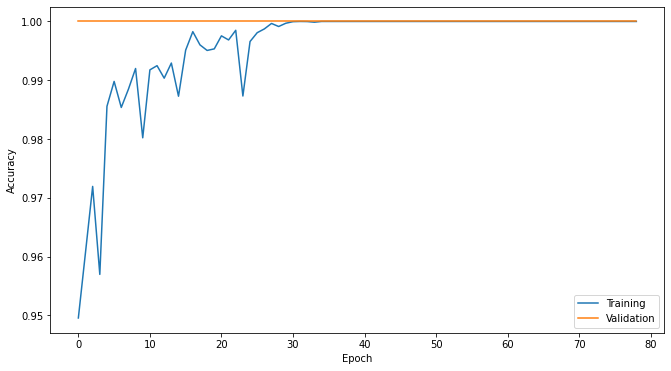

In [67]:
from matplotlib.pyplot import figure
print(trainingAccuracy)
print(validationAccuracy)
plt.figure(figsize=(11, 6))
plt.plot(trainingAccuracy[1:], label='Training')
plt.plot(validationAccuracy[1:], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show
print(max(validationAccuracy))

## Saving/Loading Trained Models

In [68]:
# Path name. 
# Be careful to not overwrite 
PATH = './MNIST_net2.pth'

In [69]:
# Saving model 
torch.save(net.state_dict(), PATH)

In [ ]:
# Loading Model 
net = Net()
net.load_state_dict(torch.load(PATH))
net.eval()

# Apply Our Model To Testing Data And Get Results

In [70]:
Y_test_NbOfDigits = torch.zeros(X_test.shape[0],1).int()
for i in range(X_test.shape[0]): 
    Y_test_NbOfDigits[i] = nbOfDigitsInImage(X_test[i])

testDigits = []
for i in range(X_test.shape[0]): 
    digits = retrieveDigits(X_test[i], Y_test_NbOfDigits[i])
    for image in range(len(digits)): 
        testDigits.append(digits[image].numpy())


X_test_CNN = torch.FloatTensor(testDigits)
X_test_CNN = X_test_CNN.reshape((X_test_CNN.shape[0],1,X_test_CNN.shape[1], X_test_CNN.shape[2]))
print(X_test_CNN.shape)
print(Y_test_NbOfDigits.shape)

torch.Size([42114, 1, 12, 12])
torch.Size([14000, 1])


In [71]:
with torch.no_grad(): 
        test_output = net(X_test_CNN)
        _, test_predicted = torch.max(test_output.data, 1)

In [72]:
print(test_predicted.shape)

torch.Size([42114])


In [73]:
groupedPrediction = torch.zeros(Y_test_NbOfDigits.shape[0],5)
groupedPrediction += 10 
i = 0 
for label in range(groupedPrediction.shape[0]): 
    nbDigits = Y_test_NbOfDigits[label]
    for digit in range(nbDigits):
        groupedPrediction[label,digit] = test_predicted[i]
        i+=1

groupedPrediction = groupedPrediction.int()
print(groupedPrediction.shape)

torch.Size([14000, 5])


Sneek peek :)

tensor([ 9, 10, 10, 10, 10], dtype=torch.int32)


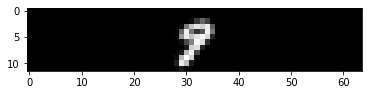

tensor([ 0,  1,  7,  3, 10], dtype=torch.int32)


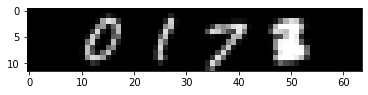

tensor([1, 4, 0, 8, 3], dtype=torch.int32)


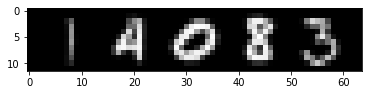

tensor([ 0, 10, 10, 10, 10], dtype=torch.int32)


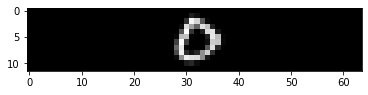

tensor([ 4,  6,  7,  8, 10], dtype=torch.int32)


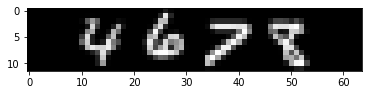

tensor([ 0, 10, 10, 10, 10], dtype=torch.int32)


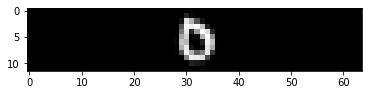

tensor([ 6,  9,  2, 10, 10], dtype=torch.int32)


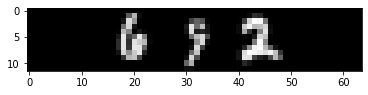

tensor([ 3,  7, 10, 10, 10], dtype=torch.int32)


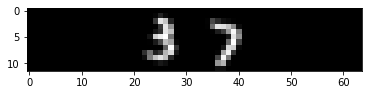

tensor([4, 8, 2, 6, 7], dtype=torch.int32)


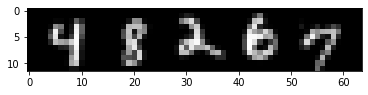

tensor([ 9,  6,  6,  0, 10], dtype=torch.int32)


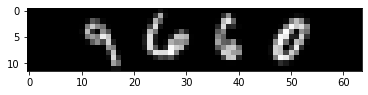

In [42]:
for i in np.arange(10): 
    testImage = X_test[i]
    fig, ax0 = plt.subplots()
    ax0.imshow(testImage, cmap='gray')
    print(groupedPrediction[i])
    plt.show()

## Formatting Into CSV And Saving Results

In [74]:
import csv
with open('testResults5.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Label"])
    for i in range(groupedPrediction.shape[0]): 
        res_String = ""
        pred = groupedPrediction[i].numpy().astype(np.str)
        for j in range(pred.shape[0]): 
            res_String+=pred[j]
        writer.writerow([i, res_String])